# PHASE 1: Fine-tuning VGG
This file contains code to 1) fine-tune the last layers of the pretrained network to make it emotion relevant. 2) To evaluate the fine-tuning process. We perform fine-tuning as the pretrained network is trained on a face recognition dataset so we preserve most of the layers but update the weights for only the last few dense layers to customize it to an emotion recognition task. FER2013 is a static emotion dataset used for fine-tuning. After fine-tuning you could classify emotions directly frame by frame even on a video dataset, but we wanted to model it as a video sequence classification. This custom CNN network will then be used to extract features (before it is fed to RNN) for our main video-dataset: Enterface. 

In [9]:
#Do this method to extract files! 
import zipfile36 as zipfile 
from zipfile import ZipFile

#filename = "Data_FER.zip"
filename = "Data_FER_6classes.zip"
with ZipFile(filename,'r') as zip:
    zip.extractall(path= "FERdataset")

In [14]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.engine import  Model
from keras.layers import Flatten, Dense, Input, Dropout, BatchNormalization
from keras_vggface.vggface import VGGFace
import cv2
import numpy as np
import matplotlib as plt
import dlib
import pandas as pd

In [6]:
import keras
from keras.preprocessing import image
from keras_vggface.vggface import VGGFace
from keras_vggface import utils
from numpy import asarray
from PIL import Image

# img = image.load_img('../image/ajb.jpg', target_size=(224, 224))
# x = image.img_to_array(img)
# x = np.expand_dims(x, axis=0)
# x = utils.preprocess_input(x, version=1) # or version=2
# preds = model.predict(x)

detector = dlib.get_frontal_face_detector()

def preprocess_function(x):
    x = image.img_to_array(x)
    #x = face_detection(x)
    x = np.expand_dims(x, axis=0)  
    x = utils.preprocess_input(x, version=1)
    return x

def face_detection(img):
    faces = detector(img)
    for face in faces:
        x1 = face.left()
        y1 = face.top()
        x2 = face.right()
        y2 = face.bottom()
        img = img[y1:y2, x1:x2]
        return img
    

train_datagen = ImageDataGenerator(shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        preprocessing_function = preprocess_function)
        #rescale=1./255,
        #shear_range=0.2,
        #zoom_range=0.2,
        #horizontal_flip=True

test_datagen = ImageDataGenerator(preprocessing_function = preprocess_function)


#training_path = "FERdataset/Data_FER/Training"
training_path = "FERdataset/Data_FER_6classes/Training"
train_generator = train_datagen.flow_from_directory(
    directory= training_path,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=64,
    class_mode="categorical",
    shuffle=True,
    seed=42)

#validation_path = "/content/drive/My Drive/"+my_dir+"/Data_FER/PublicTest"
#validation_path = "FERdataset/Data_FER/PublicTest"
validation_path = "FERdataset/Data_FER_6classes/PublicTest"

valid_generator = test_datagen.flow_from_directory(
    directory= validation_path,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=64,
    class_mode="categorical",
    shuffle=True,
    seed=42)


Found 23744 images belonging to 6 classes.
Found 2982 images belonging to 6 classes.


In [3]:
import matplotlib.pyplot as plt
x,y = train_generator.next()
print(x[0])
print(x[0].shape)
print(y.shape)
# for i in range(0,1):
#     #image = x[i]
#     image = x[i]
#     print(np.shape(image))
#     plt.figure(figsize=(10,10))
#     plt.imshow(image)

[[[ -48.594     -59.762398  -84.186295]
  [ -48.594     -59.762398  -84.186295]
  [ -48.594     -59.762398  -84.186295]
  ...
  [ -73.33697   -84.50536  -108.92926 ]
  [ -73.33446   -84.50285  -108.92675 ]
  [ -73.33194   -84.500336 -108.92423 ]]

 [[ -48.594     -59.762398  -84.186295]
  [ -48.594     -59.762398  -84.186295]
  [ -48.594     -59.762398  -84.186295]
  ...
  [ -75.594     -86.7624   -111.186295]
  [ -75.594     -86.7624   -111.186295]
  [ -75.594     -86.7624   -111.186295]]

 [[ -48.594     -59.762398  -84.186295]
  [ -48.594     -59.762398  -84.186295]
  [ -48.594     -59.762398  -84.186295]
  ...
  [ -75.594     -86.7624   -111.186295]
  [ -75.594     -86.7624   -111.186295]
  [ -75.594     -86.7624   -111.186295]]

 ...

 [[ -21.594002  -32.762398  -57.186295]
  [ -21.594002  -32.762398  -57.186295]
  [ -21.594002  -32.762398  -57.186295]
  ...
  [  74.406      63.237602   38.813705]
  [  74.406      63.237602   38.813705]
  [  74.406      63.237602   38.813705]]

 [

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


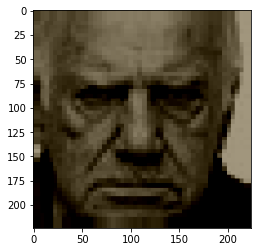

In [4]:
#plt.imshow(x[0]/255)
plt.imshow(x[53]/255, cmap="gray")

In [5]:
nb_class = 6
vgg_model = VGGFace(include_top=False, input_shape=(224, 224, 3))
last_layer = vgg_model.get_layer('pool5').output
x = Flatten(name='flatten')(last_layer)
#x = Dense(hidden_dim, activation='relu', name='fc6')(x)
x = Dense(4096, activation='relu', name='fc6')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(2048, activation = 'relu', name = 'fc7')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
#x = Dense(hidden_dim, activation='relu', name='fc7')(x)
out = Dense(nb_class, activation='softmax', name='fc8')(x)
custom_vgg_model = Model(inputs = vgg_model.input, outputs = out)

layer_count = 0
for layer in custom_vgg_model.layers:
    layer_count = layer_count+1
for l in range(layer_count-6): #-3
    custom_vgg_model.layers[l].trainable=False

custom_vgg_model.summary()

for layer in custom_vgg_model.layers:
    print("{}: {}".format(layer, layer.trainable))
 
custom_vgg_model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_____________________________________________________

In [6]:
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Conv2D,MaxPooling2D,Flatten,Dropout,BatchNormalization
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from tensorflow import keras
#from utils.cifar_utils import load_data


epc = 15 #number of epoches
#train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies
#train_generator = train_datagen.flow(X_train, Y_train, batch_size=bs)
step_size_train=train_generator.n//train_generator.batch_size
step_size_valid = valid_generator.n//valid_generator.batch_size


In [7]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8)

history = custom_vgg_model.fit_generator(generator = train_generator,
                   steps_per_epoch = step_size_train,
                   epochs = epc,
                   validation_data=valid_generator,
                   validation_steps = step_size_valid, callbacks = [es])

Instructions for updating:
Use tf.cast instead.
Epoch 1/15
371/371 [==============================] - 334s 901ms/step - loss: 1.5282 - accuracy: 0.5555 - val_loss: 0.9575 - val_accuracy: 0.6349
Epoch 2/15
371/371 [==============================] - 328s 884ms/step - loss: 0.9719 - accuracy: 0.6321 - val_loss: 0.6436 - val_accuracy: 0.6354
Epoch 3/15
371/371 [==============================] - 323s 870ms/step - loss: 0.9207 - accuracy: 0.6553 - val_loss: 1.1769 - val_accuracy: 0.6484
Epoch 4/15
371/371 [==============================] - 322s 867ms/step - loss: 0.8594 - accuracy: 0.6779 - val_loss: 1.0424 - val_accuracy: 0.6494
Epoch 5/15
371/371 [==============================] - 319s 860ms/step - loss: 0.8093 - accuracy: 0.6949 - val_loss: 0.7595 - val_accuracy: 0.6642
Epoch 6/15
371/371 [==============================] - 323s 871ms/step - loss: 0.7557 - accuracy: 0.7160 - val_loss: 0.9062 - val_accuracy: 0.6703
Epoch 7/15
371/371 [==============================] - 322s 868ms/step - loss

In [11]:
# custom_vgg_model.save('custom_vgg_model_preproc1.h5')
# custom_vgg_model.save_weights('Outputs-FERmodels/model_preproc1_15epc_64bsEs.h5') 

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


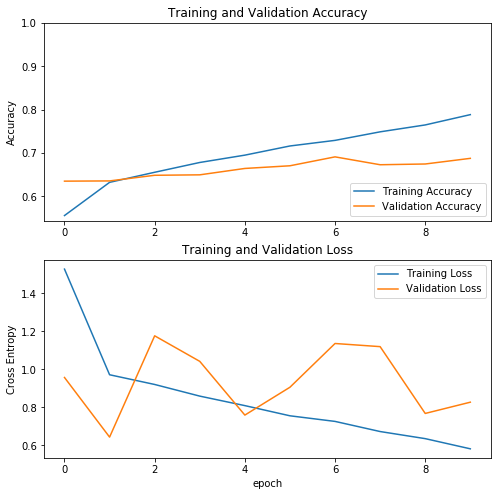

In [8]:

import matplotlib.pyplot as plt
%matplotlib inline

print(history.history.keys())
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')

plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [10]:
custom_vgg_model = keras.models.load_model('custom_vgg_model_preproc1.h5', compile = False)

In [11]:
##setup test 

from sklearn.metrics import classification_report, confusion_matrix
test_dir = "FERdataset/Data_FER_6classes/PrivateTest"
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        color_mode="rgb",
        shuffle = False,
        class_mode='categorical',
        batch_size=1)

filenames = test_generator.filenames
nb_samples = len(filenames)
predict = custom_vgg_model.predict_generator(test_generator, steps = nb_samples)
y_pred = np.argmax(predict, axis=1)
print(y_pred)
print(confusion_matrix(test_generator.classes, y_pred))

Found 2963 images belonging to 6 classes.
[0 0 2 ... 4 5 5]
[[275   2  42  35 123  14]
 [ 12  35   5   0   3   0]
 [ 63   3 225  34 151  52]
 [ 25   0  13 772  49  20]
 [ 68   0  54  57 406   9]
 [ 13   0  41  23  16 323]]


In [12]:
target_names = ['anger', 'disgust','fear', 'happiness', 'sadness', 'surprise']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

              precision    recall  f1-score   support

       anger       0.60      0.56      0.58       491
     disgust       0.88      0.64      0.74        55
        fear       0.59      0.43      0.50       528
   happiness       0.84      0.88      0.86       879
     sadness       0.54      0.68      0.61       594
    surprise       0.77      0.78      0.77       416

    accuracy                           0.69      2963
   macro avg       0.70      0.66      0.68      2963
weighted avg       0.69      0.69      0.68      2963



In [16]:
con_mat = tf.math.confusion_matrix(labels=test_generator.classes, predictions=y_pred)
sess = tf.Session()
with sess.as_default():
        print(sess.run(con_mat))
        con_array = con_mat.eval(session=sess)
con_mat_norm = np.around(con_array.astype('float') / con_array.sum(axis=1)[:, np.newaxis], decimals=2)
 
con_mat_df = pd.DataFrame(con_mat_norm,
                     index = target_names, 
                   columns = target_names)

print(con_mat_df)

figure = plt.figure(figsize=(6, 6))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
#sns.heatmap(con_mat_df, annot=True)
#plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

[[275   2  42  35 123  14]
 [ 12  35   5   0   3   0]
 [ 63   3 225  34 151  52]
 [ 25   0  13 772  49  20]
 [ 68   0  54  57 406   9]
 [ 13   0  41  23  16 323]]
           anger  disgust  fear  happiness  sadness  surprise
anger       0.56     0.00  0.09       0.07     0.25      0.03
disgust     0.22     0.64  0.09       0.00     0.05      0.00
fear        0.12     0.01  0.43       0.06     0.29      0.10
happiness   0.03     0.00  0.01       0.88     0.06      0.02
sadness     0.11     0.00  0.09       0.10     0.68      0.02
surprise    0.03     0.00  0.10       0.06     0.04      0.78


AttributeError: module 'matplotlib' has no attribute 'figure'